In [ ]:
# !git clone https://github.com/Dinith132/steel-industry-energy-consumption.git

In [ ]:
#  cd steel-industry-energy-consumption/with_down/4.Eve/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
import pickle


# ***edit***

In [ ]:
continue_path="with_down/remove_co2&log_1"
base_path = f"/content/drive/MyDrive/Shared-Colab-Storage/{continue_path}"
df=pd.read_csv(f"{base_path}/data.csv")

In [ ]:
def create_sliding_windows(data, window_size=1):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size, 1:])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

In [ ]:
data={}
df_np = df.to_numpy()
window_sizes=[1,4,8,12,16,24,36,48,74,168,336,672]

for window in window_sizes:
  X, y = create_sliding_windows(df_np, window)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)
  data[f"win{window}"] = {
      "X_train": X_train,
      "X_test": X_test,
      "y_train": y_train,
      "y_test": y_test
  }

In [ ]:
# data['win1']['X_train'].shape, data['win1']['y_train'].shape, data['win1']['X_test'].shape, data['win1']['y_test'].shape

In [ ]:
def build_lstm_model(model_type, input_shape):
    model = Sequential()

    if model_type == 'single':
        model.add(LSTM(64, input_shape=input_shape))
    elif model_type == 'double':
        model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(64))
    elif model_type == 'bidirectional':
        model.add(Bidirectional(LSTM(64), input_shape=input_shape))

    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

In [ ]:
import tensorflow.keras.backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [ ]:
import os
import pickle
from tensorflow.keras.models import load_model

# Save model to disk
def save_model(model, window_size, model_dir):
    path = f"{model_dir}/win{window_size}.keras"
    model.save(path)

# Load model from disk
def load_saved_model(window_size, model_dir):
    path = f"{model_dir}/win{window_size}.keras"
    if os.path.exists(path):
        return load_model(path, custom_objects={'rmse': rmse})
    else:
        return None

# Save history to disk
def save_history(history, window_size , history_dir):
    path = f"{history_dir}/win{window_size}_history.pkl"
    with open(path, 'wb') as f:
        pickle.dump(history.history, f)

# Load history from disk
def load_saved_history(window_size,history_dir):
    path = f"{history_dir}/win{window_size}_history.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return None

In [ ]:

single_path=f"{base_path}/single"
double_path=f"{base_path}/double"
bidir_path=f"{base_path}/bidir"

In [ ]:
import matplotlib.pyplot as plt
import math
import os

def plot_histories_subplot(model_histories, title_prefix, save_dir, cols=3, figsize=(12, 4)):
    # save_dir=f"{save_dir}/plots"

    os.makedirs(save_dir, exist_ok=True)

    total = len(model_histories)
    rows = math.ceil(total / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    axes = axes.flatten()

    for idx, (key, content) in enumerate(model_histories.items()):
        ax = axes[idx]
        history_data = content["history"]

        if history_data:
            ax.plot(history_data['loss'], label='Train Loss')
            if 'val_loss' in history_data:
                ax.plot(history_data['val_loss'], label='Val Loss')
            ax.set_title(f"{title_prefix} - win{key}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)
        else:
            ax.set_title(f"No data for win{key}")
            ax.axis('off')

    for i in range(len(model_histories), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_loss_grid.png")
    plt.savefig(save_path)
    print(f"✅ Saved figure to: {save_path}")

    plt.show()
    plt.close()

# ***add name***

In [ ]:
plot_name="(down rm_co2+log1)"

In [ ]:
def train(stack, model_dir, history_dir, path):
  all_models = {} # Initialize a dictionary to store models and histories
  for window_size in window_sizes:
    print(f"==> Window: {window_size}")

    X_train = data[f"win{window_size}"]["X_train"]
    X_test = data[f"win{window_size}"]["X_test"]
    y_train = data[f"win{window_size}"]["y_train"]
    y_test = data[f"win{window_size}"]["y_test"]

    print("-->", X_train.shape, y_train.shape, X_test.shape)

    # Try to load the model
    model = load_saved_model(window_size, model_dir)
    history_data = load_saved_history(window_size, history_dir)

    if model is not None and history_data is not None:
        print(f"✅ Loaded model and history for window {window_size}")
        history = None  # Already loaded history_data
    else:
        print(f"🚀 Training new model for window {window_size}")
        model = build_lstm_model(f"{stack}", (window_size, X_train.shape[2]))
        model.compile(optimizer='adam', loss=rmse, metrics=['mae'])

        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        save_model(model, window_size, model_dir)
        save_history(history, window_size, history_dir)
        history_data = history.history
        print(f"💾 Model and history saved for window {window_size}")

    # Store the model and history in the all_models dictionary
    all_models[f"win{window_size}"] = {
        "model": model,
        "history": history_data  # always a dict
    }

    plot_histories_subplot(all_models, f"{stack} {plot_name}" , path) # This line was plotting after each window's training. Move plot generation outside the loop
  return all_models # Return the dictionary containing all models and histories


single

In [ ]:
single_model_dir = f"{single_path}/models"
single_history_dir = f"{single_path}/history"
os.makedirs(single_model_dir, exist_ok=True)
os.makedirs(single_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
==> Window: 336
--> (6907, 336, 8) (6907,) (1517

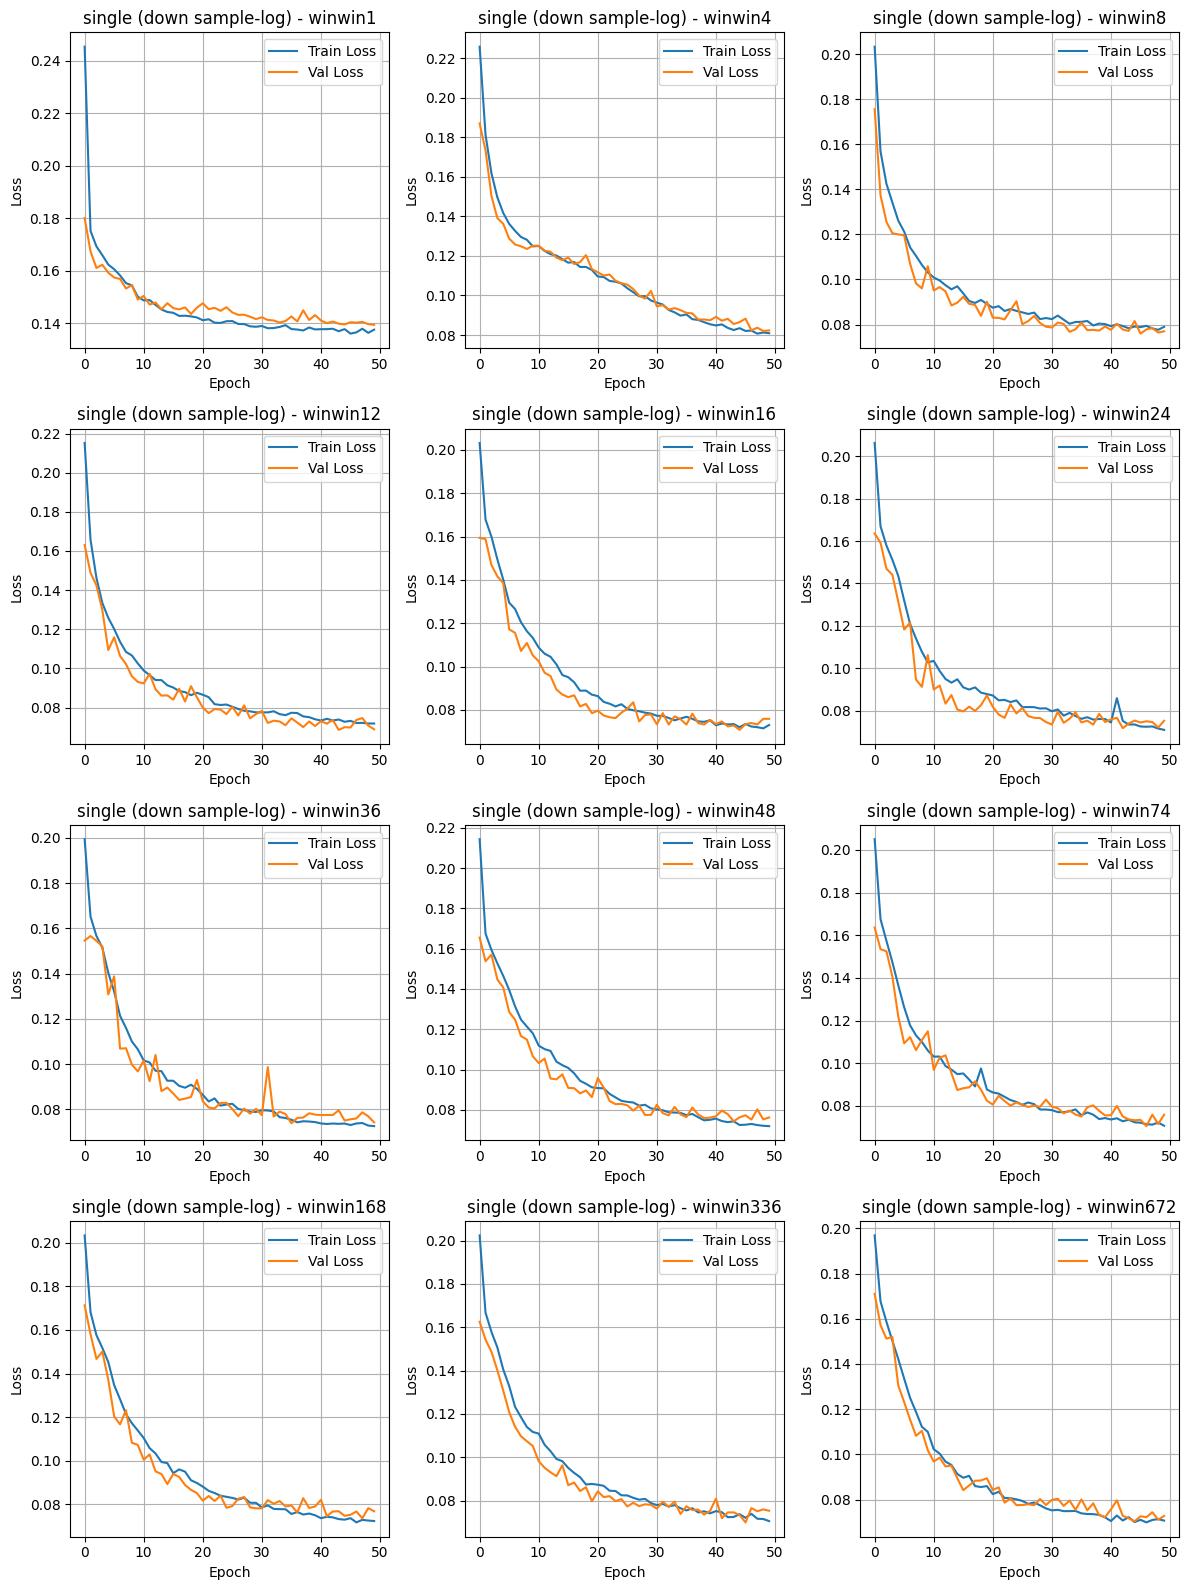

In [ ]:
single_models = train("single", single_model_dir, single_history_dir, single_path)
# plot_histories_subplot(single_models, f"single {plot_name}")

double

In [ ]:
double_model_dir = f"{double_path}/models"
double_history_dir = f"{double_path}/history"
os.makedirs(double_model_dir, exist_ok=True)
os.makedirs(double_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
==> Window: 336
--> (6907, 336, 8) (6907,) (1517

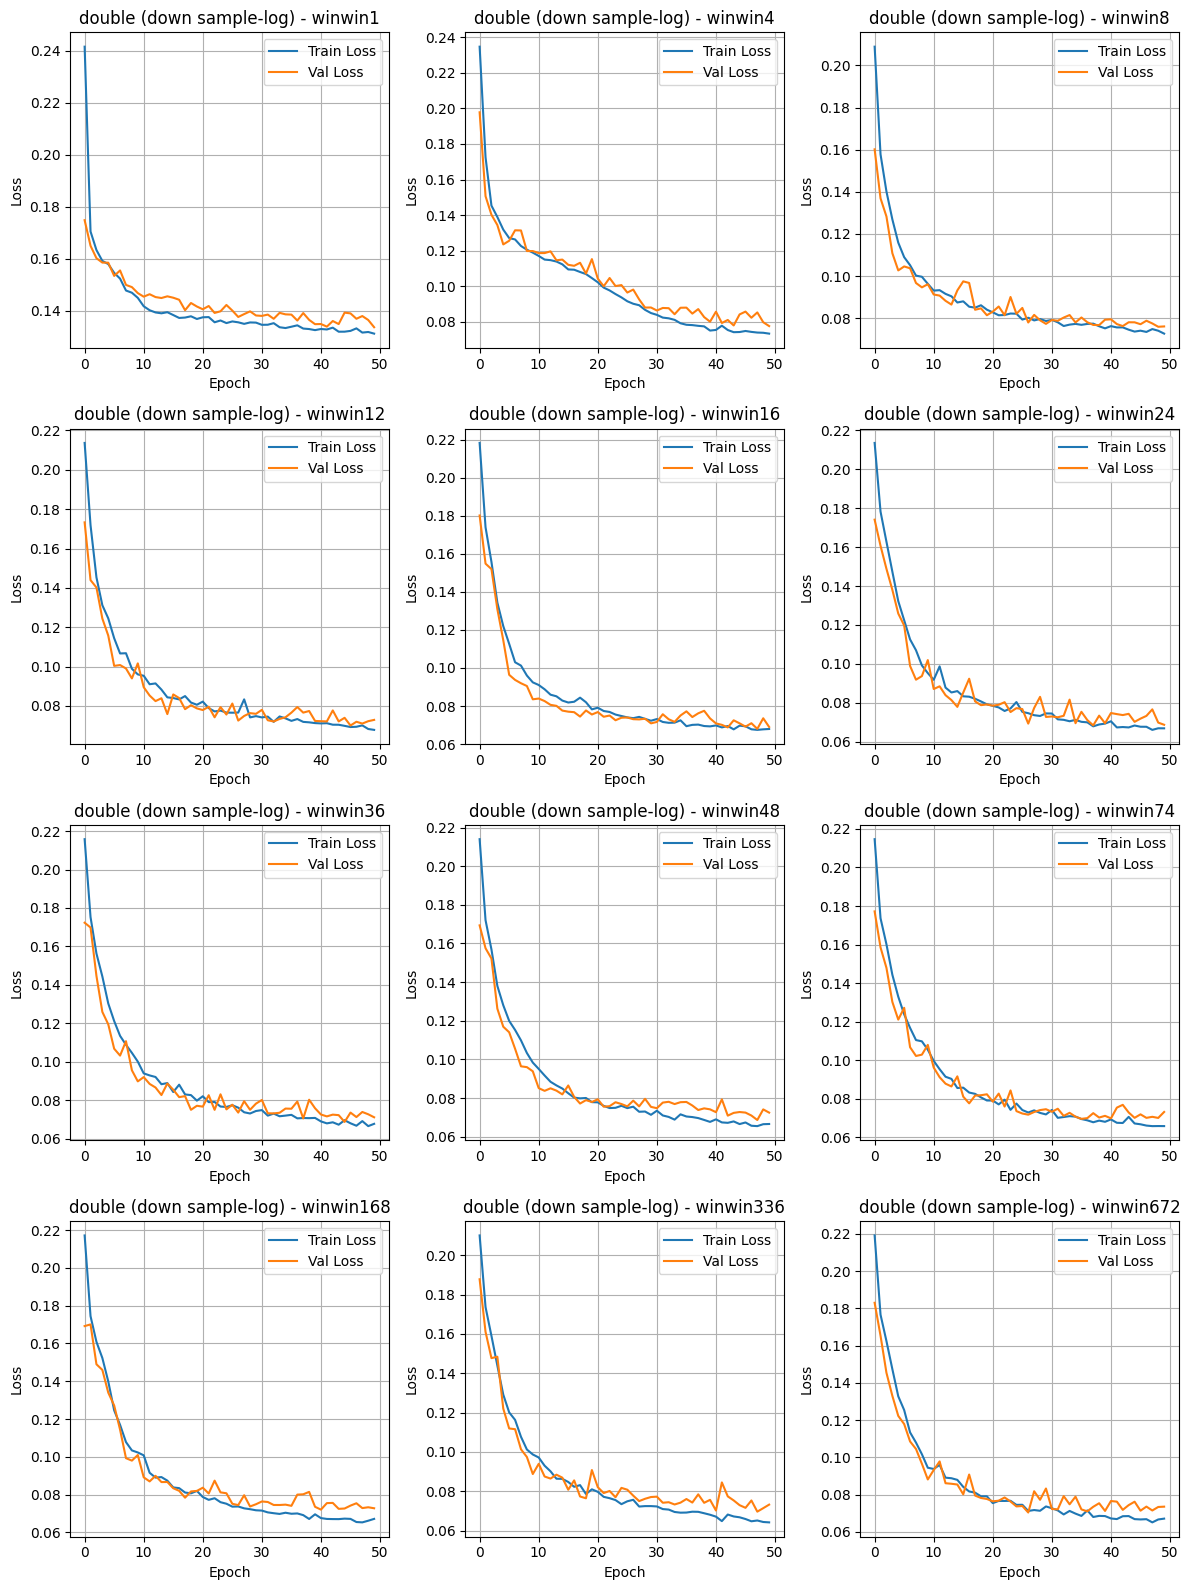

In [ ]:
double_models =train("double",double_model_dir, double_history_dir, double_path)

bi dir

In [ ]:
bidir_model_dir = f"{bidir_path}/models"
bidir_history_dir = f"{bidir_path}/history"
os.makedirs(bidir_model_dir, exist_ok=True)
os.makedirs(bidir_history_dir, exist_ok=True)

==> Window: 1
--> (7182, 1, 8) (7182,) (1577, 1, 8)
✅ Loaded model and history for window 1
==> Window: 4
--> (7179, 4, 8) (7179,) (1577, 4, 8)
✅ Loaded model and history for window 4
==> Window: 8
--> (7176, 8, 8) (7176,) (1576, 8, 8)
✅ Loaded model and history for window 8
==> Window: 12
--> (7173, 12, 8) (7173,) (1575, 12, 8)
✅ Loaded model and history for window 12
==> Window: 16
--> (7170, 16, 8) (7170,) (1574, 16, 8)
✅ Loaded model and history for window 16
==> Window: 24
--> (7163, 24, 8) (7163,) (1573, 24, 8)
✅ Loaded model and history for window 24
==> Window: 36
--> (7153, 36, 8) (7153,) (1571, 36, 8)
✅ Loaded model and history for window 36
==> Window: 48
--> (7143, 48, 8) (7143,) (1569, 48, 8)
✅ Loaded model and history for window 48
==> Window: 74
--> (7122, 74, 8) (7122,) (1564, 74, 8)
✅ Loaded model and history for window 74
==> Window: 168
--> (7045, 168, 8) (7045,) (1547, 168, 8)
✅ Loaded model and history for window 168
==> Window: 336
--> (6907, 336, 8) (6907,) (1517

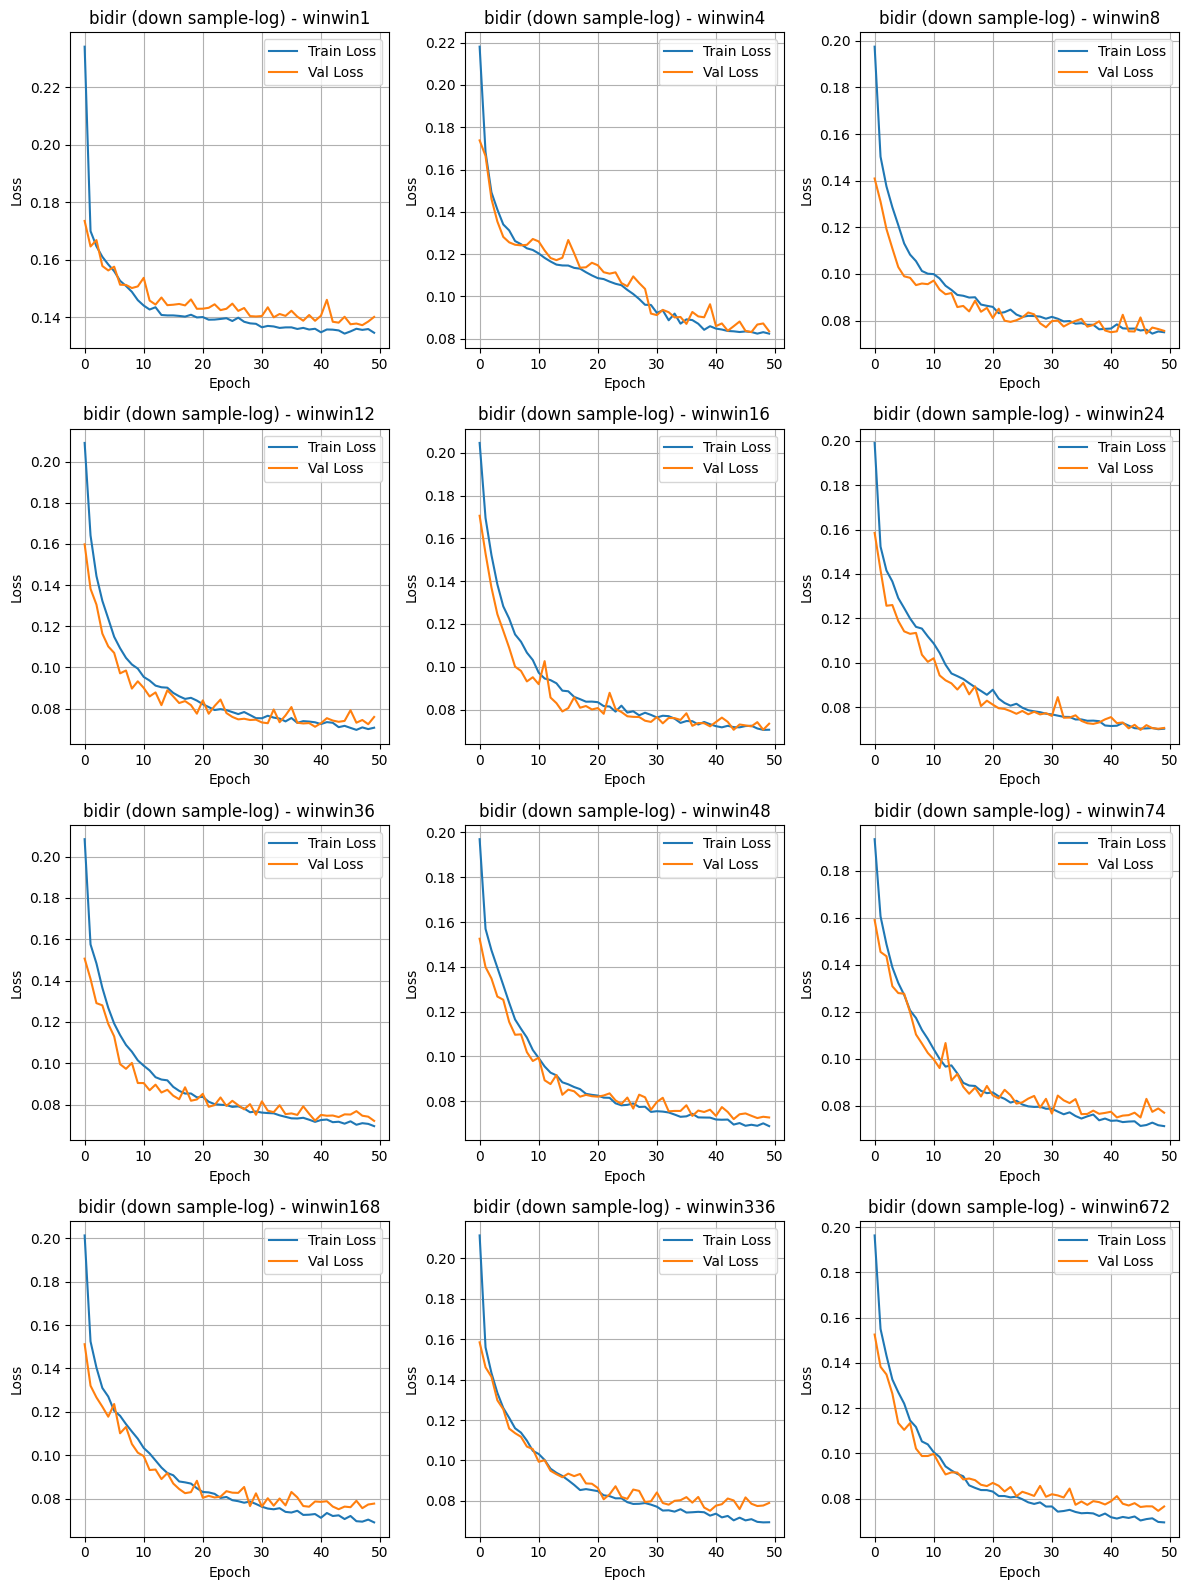

In [ ]:
bidir_models = train("bidir", bidir_model_dir, bidir_history_dir, bidir_path)

In [ ]:
# import matplotlib.pyplot as plt

# for key, content in single_models.items():
#     history_data = content["history"]
#     if history_data:
#         plt.figure()
#         plt.plot(history_data['loss'], label='Train Loss')
#         if 'val_loss' in history_data:
#             plt.plot(history_data['val_loss'], label='Val Loss')
#         plt.title(f"Loss Curve for {key}")
#         plt.legend()
#         plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_wia(y_true, y_pred):
    y_mean = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - y_mean) + np.abs(y_true - y_mean))**2)
    return 1 - (numerator / denominator) if denominator != 0 else np.nan

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    y_test = y_test.flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    wia = compute_wia(y_test, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "WIA": wia
    }


In [ ]:
model_groups = {
    "Single": single_models,
    "Double": double_models,
    "Bidirectional": bidir_models
}

evaluation_results = {}

for model_type, models_dict in model_groups.items():
    print(f"\n=== Evaluating {model_type} Models ===")
    evaluation_results[model_type] = {}

    for key, content in models_dict.items():
        model = content["model"]
        if model is None:
            print(f"❌ {model_type} model missing for {key}")
            continue

        X_test = data[key]["X_test"]
        y_test = data[key]["y_test"]

        metrics = evaluate_model(model, X_test, y_test)
        evaluation_results[model_type][key] = metrics

        print(f"{model_type} - {key} -> "
              f"RMSE: {metrics['RMSE']:.4f}, "
              f"MAE: {metrics['MAE']:.4f}, "
              f"R²: {metrics['R2']:.4f}, "
              f"WIA: {metrics['WIA']:.4f}"
              )



In [ ]:
data_for_df = []
for model_type, results_by_window in evaluation_results.items():
    for window, metrics in results_by_window.items():
        row = {"Model Type": model_type, "Window Size": window}
        row.update(metrics)
        data_for_df.append(row)

model_order = ["Single", "Double", "Bidirectional"]
window_order = [f"win{w}" for w in window_sizes]

df_eval = pd.DataFrame(data_for_df)

# Set the correct ordering as categorical indexes
df_eval["Model Type"] = pd.Categorical(df_eval["Model Type"], categories=model_order, ordered=True)
df_eval["Window Size"] = pd.Categorical(df_eval["Window Size"], categories=window_order, ordered=True)

# Now set index and reshape, order is preserved
df_eval = df_eval.set_index(["Window Size", "Model Type"])
df_eval = df_eval.unstack(level=1)

# Optional: clean up column MultiIndex
df_eval.columns = df_eval.columns.swaplevel(0, 1)
df_eval = df_eval.sort_index(axis=1, level=0, sort_remaining=False)

# Display final table
display(df_eval)

In [ ]:
# Flatten MultiIndex columns into single strings like "Single_RMSE"
df_export = df_eval.copy()
df_export.columns = [f"{model}_{metric}" for model, metric in df_export.columns]


In [ ]:
# Save to CSV
df_export.to_csv(f"{base_path}/results.csv")


# ***SHAP***

In [ ]:
import os
import matplotlib.pyplot as plt
import shap

# def generate_shap_plots(shap_data_dict, output_dir, model_type, win_key):
#     """
#     Generate and save SHAP summary and waterfall plots if they don't already exist.
#     """

#     shap_values = shap_data_dict["shap_values"]
#     test_data_flat = shap_data_dict["test_data_flat"]
#     features = shap_data_dict["features"]
#     win = shap_data_dict["window_size"]

#     summary_plot_path = os.path.join(output_dir, f'{win_key}_summary.png')
#     waterfall_plot_path = os.path.join(output_dir, f'{win_key}_waterfall_0.png')

#     # --- Summary Plot ---
#     if not os.path.exists(summary_plot_path):
#         print(f"[ ] Generating summary plot for {model_type} - {win_key}")
#         plt.figure()
#         shap.summary_plot(shap_values, test_data_flat,
#                           feature_names=features, show=False)
#         plt.title(f"SHAP Summary - {model_type} - win{win}")
#         plt.tight_layout()
#         plt.savefig(summary_plot_path)
#         plt.close()
#         print(f"[✓] Saved summary plot to {summary_plot_path}")
#     else:
#         print(f"[✓] Summary plot exists. Skipping...")

#     # --- Waterfall Plot (only sample 0) ---
#     if not os.path.exists(waterfall_plot_path):
#         print(f"[ ] Generating waterfall plot for {model_type} - {win_key} (sample 0)")
#         try:
#             explainer_obj = shap.Explanation(
#                 values=shap_values[0],
#                 data=test_data_flat,
#                 feature_names=features
#             )
#             plt.figure()
#             shap.plots.waterfall(explainer_obj[0], show=False)
#             plt.title(f"SHAP Waterfall - {model_type} - win{win} - Sample 0")
#             plt.tight_layout()
#             plt.savefig(waterfall_plot_path)
#             plt.close()
#             print(f"[✓] Saved waterfall plot to {waterfall_plot_path}")
#         except Exception as e:
#             print(f"[!] Failed to generate waterfall plot: {e}")
#     else:
#         print(f"[✓] Waterfall plot exists. Skipping...")


In [ ]:
def generate_shap_plots(shap_data_dict, output_dir, model_type, win_key):
    """
    Generate and save SHAP summary and waterfall plots with expanded feature names (time+feature).
    """

    shap_values = shap_data_dict["shap_values"]
    test_data_flat = shap_data_dict["test_data_flat"]
    features = shap_data_dict["features"]
    win = shap_data_dict["window_size"]

    summary_plot_path = os.path.join(output_dir, f'{win_key}_summary.png')
    waterfall_plot_path = os.path.join(output_dir, f'{win_key}_waterfall_0.png')

    # --- Step 1: Expand feature names with time index ---
    expanded_feature_names = [f"t{t}_{feat}" for t in range(win) for feat in features]

    # --- Summary Plot ---
    if not os.path.exists(summary_plot_path):
        print(f"[ ] Generating summary plot for {model_type} - {win_key}")
        plt.figure()
        shap.summary_plot(shap_values, test_data_flat,
                          feature_names=expanded_feature_names, show=False)
        plt.title(f"SHAP Summary - {model_type} - win{win}")
        plt.tight_layout()
        plt.savefig(summary_plot_path)
        plt.close()
        print(f"[✓] Saved summary plot to {summary_plot_path}")
    else:
        print(f"[✓] Summary plot exists. Skipping...")

    # --- Waterfall Plot (only sample 0) ---
    if not os.path.exists(waterfall_plot_path):
        print(f"[ ] Generating waterfall plot for {model_type} - {win_key} (sample 0)")
        try:
            explainer_obj = shap.Explanation(
                values=shap_values[0],
                data=test_data_flat,
                feature_names=expanded_feature_names
            )
            plt.figure()
            shap.plots.waterfall(explainer_obj[0], show=False)
            plt.title(f"SHAP Waterfall - {model_type} - win{win} - Sample 0")
            plt.tight_layout()
            plt.savefig(waterfall_plot_path)
            plt.close()
            print(f"[✓] Saved waterfall plot to {waterfall_plot_path}")
        except Exception as e:
            print(f"[!] Failed to generate waterfall plot: {e}")
    else:
        print(f"[✓] Waterfall plot exists. Skipping...")


In [ ]:
import os
import pickle
import numpy as np
import shap

model_types = ['single', 'double', 'bidir']
model_dicts = {
    'single': single_models,
    'double': double_models,
    'bidir': bidir_models
}

features = ['Lagging_Current_Reactive.Power_kVarh',
            'Leading_Current_Reactive_Power_kVarh', 
            'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
            'WeekStatus', 'Load_Type']

base_dir = f"{base_path}/shap_values"
os.makedirs(base_dir, exist_ok=True)

all_shap_values = {model_type: {} for model_type in model_types}

for model_type in model_types:
    print(f"\n--- Processing model type: {model_type} ---")
    model_store = model_dicts[model_type]
    output_dir = os.path.join(base_dir, model_type)
    os.makedirs(output_dir, exist_ok=True)

    for win in window_sizes:
        key = f'win{win}'
        shap_file = os.path.join(output_dir, f'{key}.pkl')

        if os.path.exists(shap_file):
            print(f"[✓] {shap_file} already exists. Loading...")
            with open(shap_file, "rb") as f:
                shap_data = pickle.load(f)
                all_shap_values[model_type][key] = shap_data
            generate_shap_plots(shap_data, output_dir, model_type, key)
            continue

        print(f"[ ] Computing SHAP for {model_type} - {key}...")

        try:
            model = model_store[key]['model']
            x_train = data[key]['X_train']
            x_test = data[key]['X_test']
        except KeyError:
            print(f"[!] Model or data missing for {model_type} - {key}. Skipping...")
            continue

        if len(x_train) < 200:
            print(f"[!] Not enough training data for {key}. Skipping...")
            continue

        background_data = x_train[np.random.choice(len(x_train), 200, replace=False)]
        test_data = x_test[:100]

        def model_predict(data):
            data = data.reshape(-1, win, 7)
            preds = model.predict(data, verbose=0)
            return preds.flatten()

        background_data_flat = background_data.reshape(background_data.shape[0], -1)
        test_data_flat = test_data.reshape(test_data.shape[0], -1)

        explainer = shap.KernelExplainer(model_predict, background_data_flat)
        shap_values = explainer.shap_values(test_data_flat, nsamples=100)

        # Store in memory and save to file
        shap_data = {
            "shap_values": shap_values,
            "test_data_flat": test_data_flat,
            "background_data_flat": background_data_flat,
            "features": features,
            "window_size": win,
            "model_type": model_type
        }
        all_shap_values[model_type][key] = shap_data

        with open(shap_file, "wb") as f:
            pickle.dump(shap_data, f)

        print(f"[✓] Saved SHAP to {shap_file}")

        # Generate plots
        generate_shap_plots(shap_data, output_dir, model_type, key)



--- Processing model type: single ---
[✓] /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/single/win1.pkl already exists. Loading...
[✓] Summary plot exists. Skipping...
[ ] Generating waterfall plot for single - win1 (sample 0)
[!] Failed to generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape ()) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
[✓] /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/single/win4.pkl already exists. Loading...
[✓] Summary plot exists. Skipping...
[ ] Generating waterfall plot for single - win4 (sample 0)
[!] Failed to generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape ()) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.537e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.732e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.040e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2

[✓] Saved SHAP to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/single/win672.pkl
[ ] Generating summary plot for single - win672
[✓] Saved summary plot to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/single/win672_summary.png
[ ] Generating waterfall plot for single - win672 (sample 0)
[!] Failed to generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape ()) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Processing model type: double ---
[ ] Computing SHAP for double - win1...


  0%|          | 0/100 [00:00<?, ?it/s]

[✓] Saved SHAP to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/double/win1.pkl
[ ] Generating summary plot for double - win1
[✓] Saved summary plot to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/double/win1_summary.png
[ ] Generating waterfall plot for double - win1 (sample 0)
[!] Failed to generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape ()) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
[ ] Computing SHAP for double - win4...


  0%|          | 0/100 [00:00<?, ?it/s]

[✓] Saved SHAP to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/double/win4.pkl
[ ] Generating summary plot for double - win4
[✓] Saved summary plot to /content/drive/MyDrive/Shared-Colab-Storage/with_down/log_all/shap_values/double/win4_summary.png
[ ] Generating waterfall plot for double - win4 (sample 0)
[!] Failed to generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape ()) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
[ ] Computing SHAP for double - win8...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
all_shap_values['single']['win4']['shap_values'].shape

(100, 32)

In [ ]:
len(all_shap_values['single']['win8']['shap_values'])